In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, train_test_split
import pandas as pd

import utils.load_data as ld
import utils.features as f
import utils.classifiers as clfs
import utils.variables as v
import utils.metrics as m

In [2]:
def load_and_shape_data(data_type, label_type, feature, kfold, new_ica = False):
    #Load data
    if kfold:
        train_data, test_data, train_labels, test_labels = ld.load_kfold_data(data_type, label_type, epoched = False, binary = True)
    else:
        train_data, test_data, val_data, train_labels, test_labels, val_labels = ld.load_data(data_type, label_type, epoched = True, binary = True)
        return train_data, test_data, val_data, train_labels, test_labels, val_labels
    
    print('\n---- Balanced dataset? ----')
    print(f'Number of non-stressed in train set: {np.sum(train_labels == 0)/len(train_labels)}')
    print(f'Number of non-stressed in test set: {np.sum(test_labels == 0)/len(test_labels)}')

    if feature:
        #Reshape labels to fit (n_recordings*n_channels, 1)
        train_labels = np.repeat(train_labels, repeats = v.NUM_CHANNELS, axis = 0).reshape((train_data.shape[0]*v.NUM_CHANNELS,1))
        train_labels = train_labels.ravel()

        test_labels = np.repeat(test_labels,repeats = v.NUM_CHANNELS, axis = 0).reshape((test_data.shape[0]*v.NUM_CHANNELS,1))
        test_labels = test_labels.ravel()

        print(train_data.shape)
        print(test_data.shape)
        
        #Extract features
        #time_series_features, fractal_features, entropy_features, hjorth_features, freq_band_features, kymatio_wave_scattering
        train_data = f.freq_band_features(train_data, new_ica)
        test_data = f.freq_band_features(test_data, new_ica)

        print(train_data.shape)
        print(test_data.shape)
                
        

        print(train_labels.shape)
        print(test_labels.shape)

        return train_data, test_data, train_labels, test_labels
    else:
        #Reshape data
        train_data = np.reshape(train_data, (train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
        train_labels = np.repeat(train_labels, repeats = 8, axis = 1).reshape(-1,1)
        train_labels = train_labels.ravel()

        test_data = np.reshape(test_data, (test_data.shape[0]*test_data.shape[1],test_data.shape[2]))
        test_labels = np.repeat(test_labels, repeats = 8, axis = 1).reshape(-1,1)
        test_labels = test_labels.ravel()
        return train_data, test_data, train_labels, test_labels



In [7]:
data_type = 'raw'
label_type = 'pss'
feature = True
kfold = True


train_data, test_data, train_labels, test_labels = load_and_shape_data(data_type, label_type, feature, kfold)

---- Generating all recordings ----
All records generated

---- Filtering out invalid recordings ----
ERROR 1) Failed to read data for recording P006_S002_001
ERROR 1) Failed to read data for recording P006_S002_002
ERROR 1) Failed to read data for recording P028_S002_001
ERROR 1) Failed to read data for recording P028_S002_002

---- Returning valid recordings ----
['P001_S001_001', 'P001_S001_002', 'P001_S002_001', 'P001_S002_002', 'P002_S001_001', 'P002_S001_002', 'P002_S002_001', 'P002_S002_002', 'P003_S001_001', 'P003_S001_002', 'P003_S002_001', 'P003_S002_002', 'P004_S001_001', 'P004_S001_002', 'P004_S002_001', 'P004_S002_002', 'P005_S001_001', 'P005_S001_002', 'P005_S002_001', 'P005_S002_002', 'P006_S001_001', 'P006_S001_002', 'P007_S001_001', 'P007_S001_002', 'P007_S002_001', 'P007_S002_002', 'P008_S001_001', 'P008_S001_002', 'P008_S002_001', 'P008_S002_002', 'P009_S001_001', 'P009_S001_002', 'P009_S002_001', 'P009_S002_002', 'P010_S001_002', 'P010_S002_001', 'P010_S002_002', 'P

In [8]:
print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

(320, 1250)
(320,)
(96, 1250)
(96,)


raw data with pss labels
KNeighborsClassifier(leaf_size=1, n_neighbors=2)
Number of results: 72
accuracies: [0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375
 0.6375   0.734375 0.68125  0.74375  0.625    0.684375 0.65     0.734375]


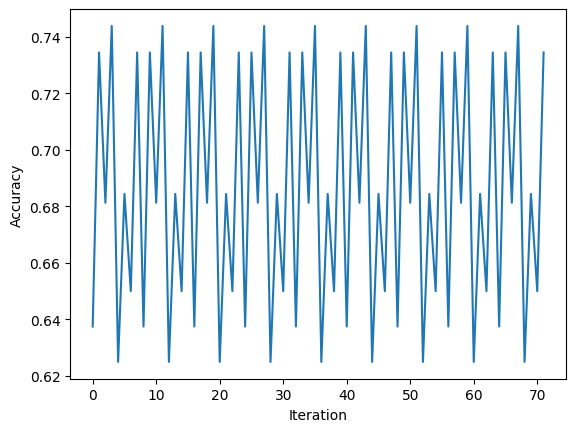

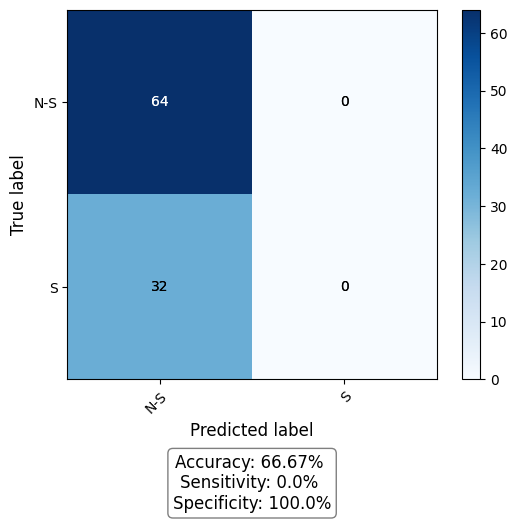

In [9]:
print(f'{data_type} data with {label_type} labels')
clfs.knn_classification(train_data, test_data, train_labels, test_labels)

raw data with pss labels
SVC(C=0.001)
Number of results: 10
accuracies: [0.775    0.775    0.775    0.775    0.759375 0.734375 0.703125 0.703125
 0.703125 0.703125]


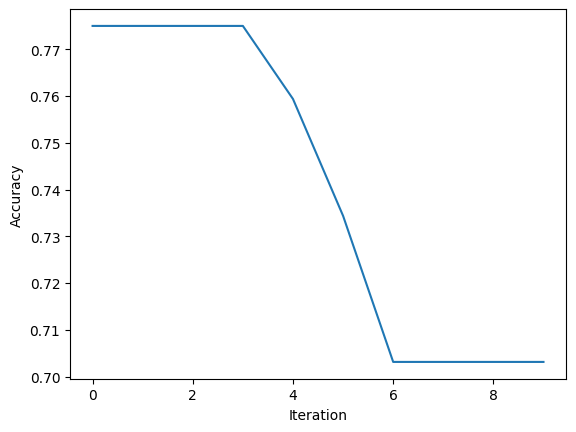

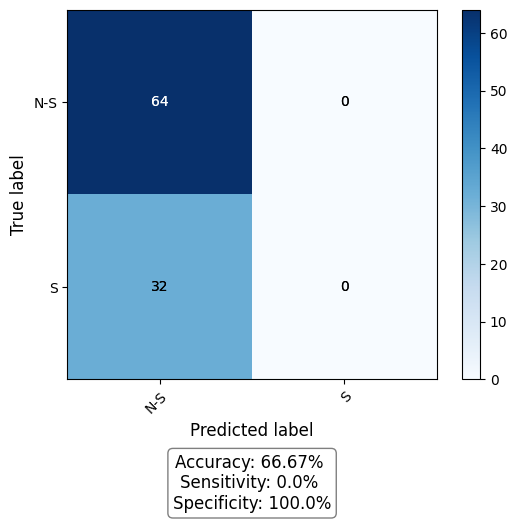

In [10]:
print(f'{data_type} data with {label_type} labels')
clfs.svm_classification(train_data, test_data, train_labels, test_labels)
